<a href="https://colab.research.google.com/github/navneetkrc/Colab_fastai/blob/master/Recommender%20Systems/GoodBooks/Book_Recommendation_System_gilbert_tanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Book Recommendation System

In [0]:
from fastai.collab import *

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

You can download dataset from [here](https://github.com/navneetkrc/Colab_fastai/tree/master/Recommender%20Systems/GoodBooks/goodbooks-10k)

In [4]:
ratings = pd.read_csv('/content/drive/My Drive/MLAI_Datasets/goodbooks-10k/ratings.csv')
ratings.head()

book_id  user_id  rating
0        1      314       5
1        1      439       3
2        1      588       5
3        1     1169       4
4        1     1185       4

In [0]:
data = CollabDataBunch.from_df(ratings, seed=42, valid_pct=0.1, user_name='user_id', item_name='book_id', rating_name='rating')

In [6]:
data.show_batch()

In [7]:
ratings.rating.min(), ratings.rating.max()

(1, 5)

## EmbeddingDotBias Model

In [0]:
learn = collab_learner(data, n_factors=40, y_range=(1, 5), wd=1e-1, model_dir="/tmp/model/", path="/tmp/")

In [9]:
print(learn.summary())
# This gives us User Embeddings, Item EMbeddings, User Bias, and Item Bias

EmbeddingDotBias
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [40]                 2,134,040  True      
______________________________________________________________________
Embedding            [40]                 400,040    True      
______________________________________________________________________
Embedding            [1]                  53,351     True      
______________________________________________________________________
Embedding            [1]                  10,001     True      
______________________________________________________________________

Total params: 2,597,432
Total trainable params: 2,597,432
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : FlattenedLoss
Callbacks functions applied 



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


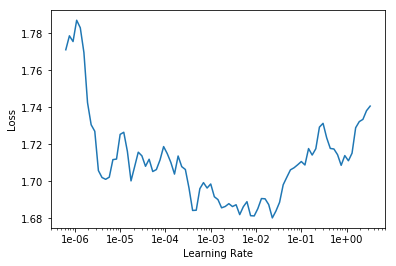

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(5, 3e-4)

In [0]:
learn.save('goodbooks-dot-1')

## EmbeddingNN Model

In [0]:
learn = collab_learner(data, use_nn=True, emb_szs={'user_id': 40, 'book_id':40}, layers=[256, 128], y_range=(1, 5))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


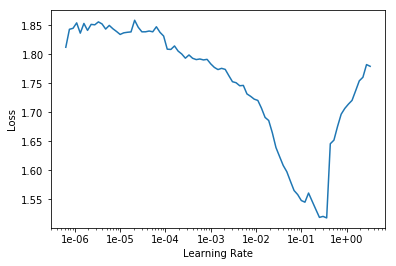

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(5, 1e-2)

In [0]:
learn.save('goodbooks-nn-1')

## Interpretation

In [0]:
learn = collab_learner(data, n_factors=40, y_range=(1, 5), wd=1e-1, model_dir="/tmp/model/", path="/tmp/")
learn.load('goodbooks-dot-1');

In [37]:
books = pd.read_csv('/content/drive/My Drive/MLAI_Datasets/goodbooks-10k/books.csv')
books.head()

id  ...                                    small_image_url
0   1  ...  https://images.gr-assets.com/books/1447303603s...
1   2  ...  https://images.gr-assets.com/books/1474154022s...
2   3  ...  https://images.gr-assets.com/books/1361039443s...
3   4  ...  https://images.gr-assets.com/books/1361975680s...
4   5  ...  https://images.gr-assets.com/books/1490528560s...

[5 rows x 23 columns]

In [38]:
g = ratings.groupby('book_id')['rating'].count()
top_books = g.sort_values(ascending=False).index.values[:1000]
top_books = top_books.astype(str)
top_books[:10]

array(['5000', '3315', '3313', '3312', '3311', '3309', '3308', '3307', '3306', '3304'], dtype='<U21')

In [39]:
g = ratings.groupby('book_id')['rating'].count()
g

book_id
1        100
2        100
3        100
4        100
5        100
6        100
7        100
8        100
9        100
10       100
11       100
12       100
13       100
14       100
15       100
16       100
17       100
18       100
19       100
20       100
21       100
22       100
23       100
24       100
25       100
26       100
27       100
28       100
29       100
30       100
        ... 
9971      68
9972      99
9973      92
9974      99
9975      99
9976     100
9977     100
9978      95
9979      84
9980      59
9981     100
9982      97
9983      67
9984      95
9985      95
9986      64
9987      95
9988      94
9989      88
9990     100
9991      97
9992      92
9993      90
9994     100
9995     100
9996      98
9997      89
9998      95
9999      99
10000     96
Name: rating, Length: 10000, dtype: int64

In [40]:
# create array containing the names of the top books
top_books_with_name = []
for book in top_books:
    top_books_with_name.append(books[(books['id']==int(book))]['title'].iloc[0])
top_books_with_name = np.array(top_books_with_name)
top_books_with_name

array(['Passion Unleashed (Demonica #3)', 'My Story', 'The Gargoyle', 'Pretty Baby', ...,
       'Top Secret Twenty-One (Stephanie Plum, #21)', 'The Warrior Heir (The Heir Chronicles, #1)', 'Stone Soup',
       'The Sixth Man (Sean King & Michelle Maxwell, #5)'], dtype='<U144')

## Book Bias

In [41]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(53351, 40)
  (i_weight): Embedding(10001, 40)
  (u_bias): Embedding(53351, 1)
  (i_bias): Embedding(10001, 1)
)

In [0]:
book_bias = learn.bias(top_books, is_item=True)

In [0]:
mean_ratings = ratings.groupby('book_id')['rating'].mean()
book_ratings = [(b, top_books_with_name[i], mean_ratings.loc[int(tb)]) for i, (tb, b) in enumerate(zip(top_books, book_bias))]

In [0]:
item0 = lambda o:o[0]

In [45]:
sorted(book_ratings, key=item0)[:15]

[(tensor(-0.0993), 'The Almost Moon', 2.49),
 (tensor(-0.0363), 'Skinny Bitch', 2.9),
 (tensor(-0.0356), 'The Particular Sadness of Lemon Cake', 2.93),
 (tensor(-0.0351), 'Bergdorf Blondes', 3.0),
 (tensor(-0.0116), 'Swamplandia!', 3.02),
 (tensor(-0.0087), 'The Weird Sisters', 3.08),
 (tensor(-0.0084), 'Nightfall (The Vampire Diaries: The Return, #1)', 3.12),
 (tensor(0.0010),
  'The Claiming of Sleeping Beauty (Sleeping Beauty, #1)',
  3.28),
 (tensor(0.0032), 'Vampire Kisses (Vampire Kisses, #1)', 3.18),
 (tensor(0.0043), 'Need (Need, #1)', 3.22),
 (tensor(0.0053), 'Last Night at Chateau Marmont', 3.07),
 (tensor(0.0104), 'The Appeal', 3.4),
 (tensor(0.0126), 'Wreckage', 3.13),
 (tensor(0.0169), 'Skipping Christmas', 3.25),
 (tensor(0.0171), 'Ink Exchange (Wicked Lovely, #2)', 3.29)]

In [27]:
sorted(book_ratings, key=item0, reverse=True)[:15]

[(tensor(0.3107), 'The Kindly Ones (The Sandman #9)', 4.65),
 (tensor(0.3047), 'The Wake (The Sandman #10)', 4.65),
 (tensor(0.3022),
  'Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)',
  4.77),
 (tensor(0.2999), 'The Complete Calvin and Hobbes', 4.73),
 (tensor(0.2998), 'Just Mercy: A Story of Justice and Redemption', 4.51),
 (tensor(0.2978),
  'The Story of the Lost Child (The Neapolitan Novels, #4)',
  4.38),
 (tensor(0.2928),
  'Harry Potter and the Chamber of Secrets: Sheet Music for Flute with C.D',
  4.57),
 (tensor(0.2896), 'The Story of a New Name (The Neapolitan Novels #2)', 4.23),
 (tensor(0.2893), 'The Arrival', 4.45),
 (tensor(0.2888), 'Crooked Kingdom (Six of Crows, #2)', 4.55),
 (tensor(0.2883), 'The Bands of Mourning (Mistborn, #6)', 4.37),
 (tensor(0.2883), 'A Game of You (The Sandman #5)', 4.56),
 (tensor(0.2881), 'Saga, Vol. 3 (Saga, #3)', 4.54),
 (tensor(0.2874), 'Nimona', 4.4),
 (tensor(0.2873), 'Saga, Vol. 4 (Saga, #4)', 4.5)]

In [46]:
book_w = learn.weight(top_books, is_item=True)
book_w.shape

torch.Size([1000, 40])

In [47]:
book_pca = book_w.pca(3)
book_pca.shape

torch.Size([1000, 3])

In [0]:
fac0,fac1,fac2 = book_pca.t()
book_comp = [(f, i) for f,i in zip(fac0, top_books_with_name)]

In [49]:
sorted(book_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.6472), 'The Darkest Kiss (Lords of the Underworld #2)'),
 (tensor(0.6170), 'Driven (Driven, #1)'),
 (tensor(0.6052), 'Come Away with Me (With Me in Seattle, #1)'),
 (tensor(0.6017), 'The Proposition (The Proposition, #1)'),
 (tensor(0.5982), 'Beautiful Stranger (Beautiful Bastard, #2)'),
 (tensor(0.5956), 'Fueled (Driven, #2)'),
 (tensor(0.5933), 'Night Play (Dark-Hunter #5, Were-Hunter #1)'),
 (tensor(0.5898), 'Pulse (Collide, #2)'),
 (tensor(0.5883), 'The Darkest Pleasure (Lords of the Underworld #3)'),
 (tensor(0.5673), 'Backstage Pass (Sinners on Tour, #1)')]

In [50]:
sorted(book_comp, key=itemgetter(0))[:10]

[(tensor(-0.6871), 'The Kindly Ones (The Sandman #9)'),
 (tensor(-0.6408), 'A Game of You (The Sandman #5)'),
 (tensor(-0.5965), 'The Complete Calvin and Hobbes'),
 (tensor(-0.5698), "Worlds' End (The Sandman #8)"),
 (tensor(-0.5690), 'The Wake (The Sandman #10)'),
 (tensor(-0.5232), 'The Road Not Taken and Other Poems'),
 (tensor(-0.5113),
  "The Hitchhiker's Guide to the Galaxy: A Trilogy in Four Parts"),
 (tensor(-0.5091), 'The Real Mother Goose'),
 (tensor(-0.4985), 'Fables and Reflections (The Sandman #6)'),
 (tensor(-0.4674), 'The Bands of Mourning (Mistborn, #6)')]

In [0]:
book_comp = [(f, i) for f,i in zip(fac1, top_books_with_name)]

In [52]:
sorted(book_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.5943),
  "Wicked Deeds on a Winter's Night (Immortals After Dark #4)"),
 (tensor(0.5900), 'Night Play (Dark-Hunter #5, Were-Hunter #1)'),
 (tensor(0.5699), 'No Rest for the Wicked (Immortals After Dark #3)'),
 (tensor(0.5634), 'Frost Burned (Mercy Thompson, #7)'),
 (tensor(0.5541), 'Passion Unleashed (Demonica #3)'),
 (tensor(0.5504), 'Magic Slays (Kate Daniels, #5)'),
 (tensor(0.5488), 'River Marked (Mercy Thompson, #6)'),
 (tensor(0.5462), 'Hunting Ground (Alpha & Omega, #2)'),
 (tensor(0.5454), 'Vampire Academy: The Ultimate Guide (Vampire Academy)'),
 (tensor(0.5410), 'The Darkest Pleasure (Lords of the Underworld #3)')]

In [53]:
sorted(book_comp, key=itemgetter(0))[:10]

[(tensor(-0.4126), 'The Weird Sisters'),
 (tensor(-0.3672), 'Skinny Bitch'),
 (tensor(-0.3549), 'Zoo'),
 (tensor(-0.3519), 'The Almost Moon'),
 (tensor(-0.3506), 'The Appeal'),
 (tensor(-0.3413), 'The Particular Sadness of Lemon Cake'),
 (tensor(-0.3337), 'Chocolate Chip Cookie Murder (Hannah Swensen, #1)'),
 (tensor(-0.3232), 'Wreckage'),
 (tensor(-0.3227), 'Swamplandia!'),
 (tensor(-0.3037), 'Beach Road')]

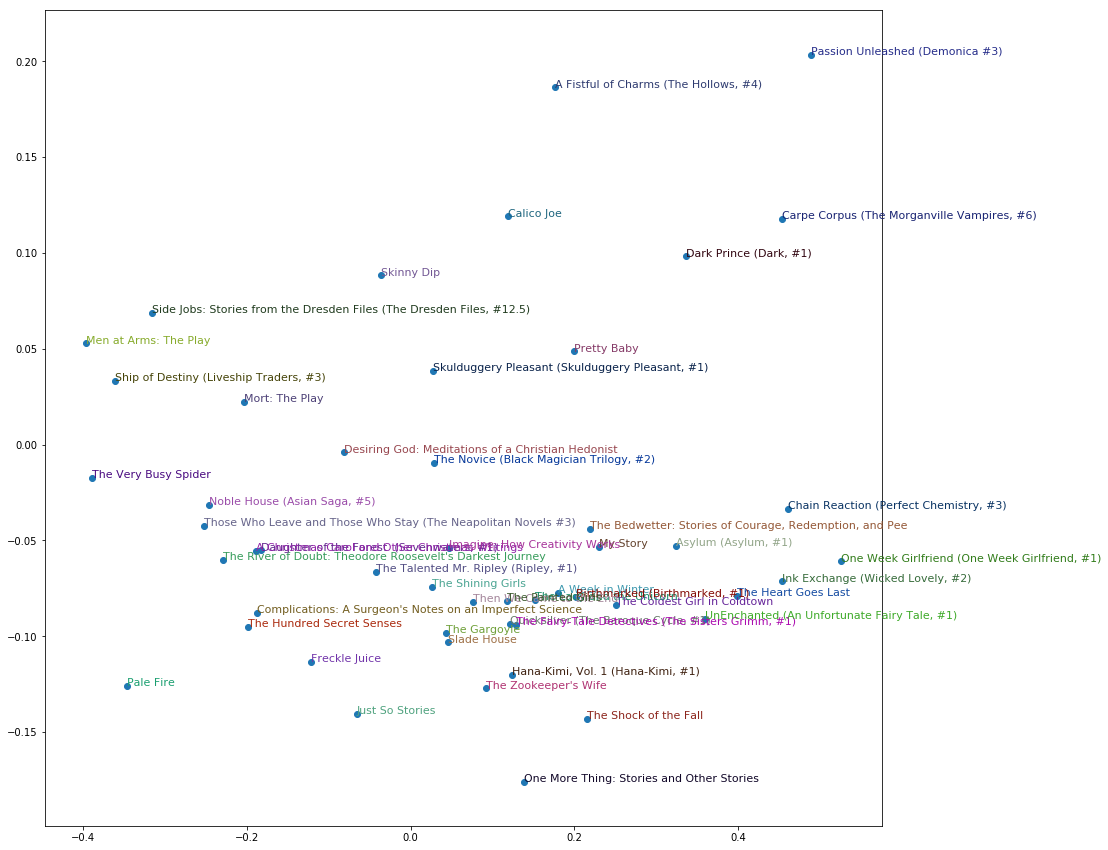

In [54]:
idxs = np.random.choice(len(top_books_with_name), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_books_with_name[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()